In [131]:
# 1. Data Import and Basic Overview
import pandas as pd
import numpy as np
# load dataset
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')

# View basic information
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [132]:
# 2. Data Preprocessing
# Handle missing values, outliers, and data inconsistencies.

# Check for missing values (good first step!)
missing_values = df.isnull().sum()
print("Missing values before processing:\n", missing_values)

# Fill missing values in 'bytes_in' with its median
# We're re-assigning the result to avoid the FutureWarning
df['bytes_in'] = df['bytes_in'].fillna(df['bytes_in'].median())

# Drop rows where 'src_ip' or 'dst_ip' are missing
# Using inplace=True here is generally fine because it's on the DataFrame directly
df.dropna(subset=['src_ip', 'dst_ip'], inplace=True)

# Convert 'creation_time' and 'end_time' to datetime objects
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

print("\nMissing values after processing:\n", df.isnull().sum())
print("\nDatatypes after conversion:\n", df[['creation_time', 'end_time']].dtypes)

Missing values before processing:
 bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

Missing values after processing:
 bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

Datatypes after conversion:
 creation_time    datetime64[ns, UTC]
end_time         datetime64[ns, UTC]


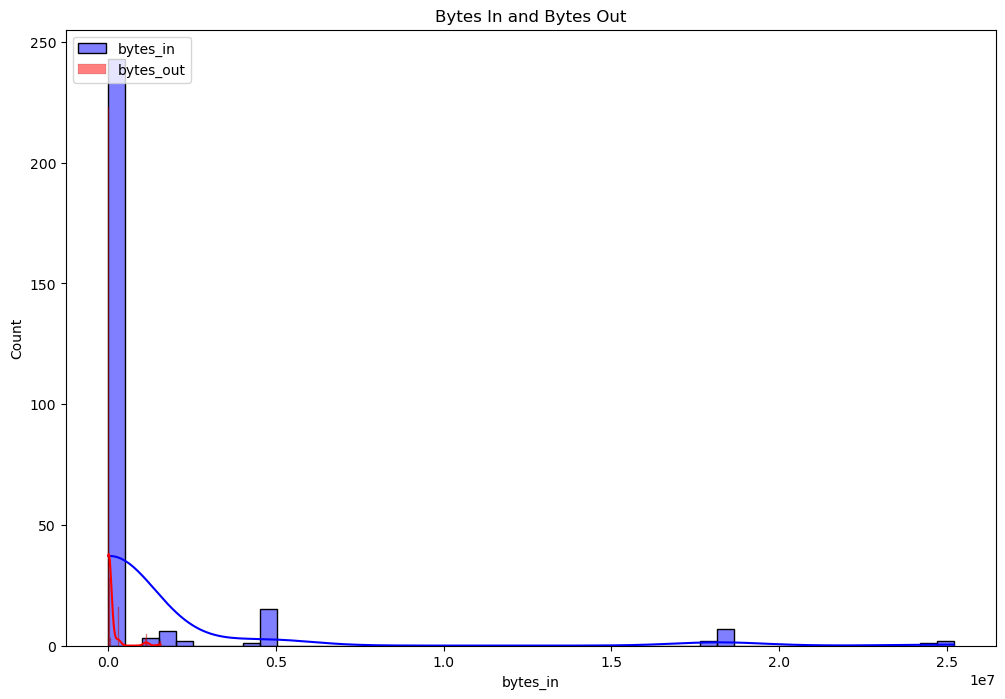

In [133]:
# 3. Exploratory Data Analysis (EDA)
# Analyze Traffic Patterns Based on bytes_in and bytes_out

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of bytes in and bytes out
plt.figure(figsize=(12, 8))
sns.histplot(df['bytes_in'], bins=50 , color='blue' , kde=True , label='bytes_in')
sns.histplot(df['bytes_out'] , bins=50 , color='red' , kde=True , label='bytes_out')
plt.legend(loc='upper left')
plt.title('Bytes In and Bytes Out')
plt.show()

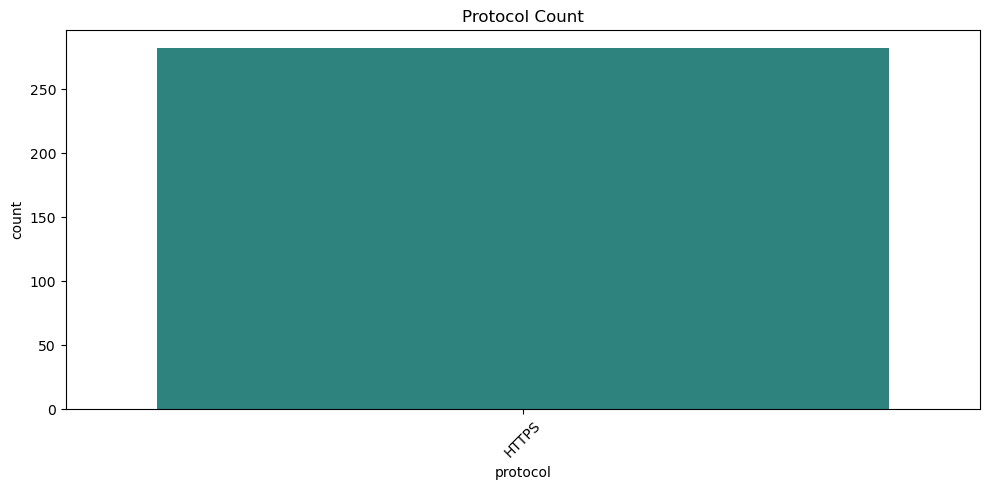

In [134]:
# Count of Protocols Used
plt.figure(figsize=(10, 5))
sns.countplot(
    x='protocol',
    hue='protocol',        # Add this line
    data=df,
    palette='viridis',
    legend=False           # Suppress the legend since hue is same as x
)
plt.title('Protocol Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [135]:
#4.Feature Engineering
# 1. Convert 'creation_time' and 'end_time' to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

# 2. Subtract to get duration in seconds
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# 3. Create total_bytes if not already created
df['total_bytes'] = df['bytes_in'] + df['bytes_out']

# 4. Calculate transfer rate
df['transfer_rate_bps'] = df['total_bytes'] / df['session_duration']

# 5. Handle inf and NaN values
df['transfer_rate_bps'] = df['transfer_rate_bps'].replace([np.inf, -np.inf], np.nan)
df['transfer_rate_bps'] = df['transfer_rate_bps'].fillna(0)


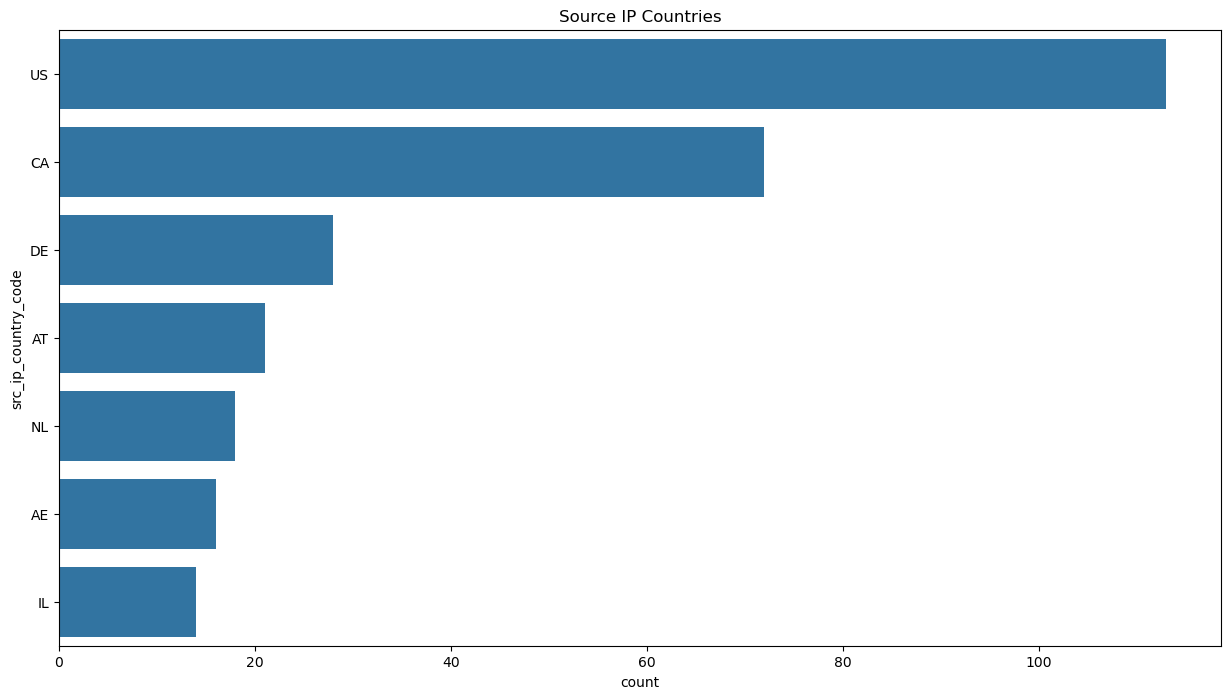

In [136]:
# 5. Data Visualization
# Country-based Interaction Analysis

plt.figure(figsize=(15,8))
sns.countplot(y='src_ip_country_code', data=df,
order=df['src_ip_country_code'].value_counts().index)
plt.title('Source IP Countries')
plt.show()


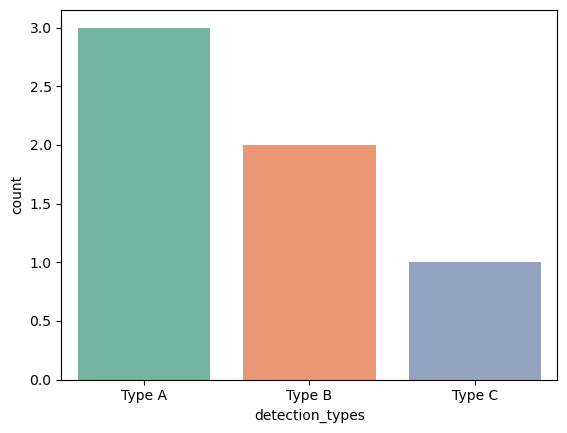

In [137]:

# Assuming 'df' is your DataFrame and 'detection_types' is the column you're plotting
# Example DataFrame (replace with your actual data)
data = {'detection_types': ['Type A', 'Type B', 'Type A', 'Type C', 'Type B', 'Type A']}
df = pd.DataFrame(data)

# Modified code to address the FutureWarning
sns.countplot(x='detection_types', data=df, hue='detection_types', palette='Set2', legend=False)
plt.show()

In [138]:
print(df.columns.tolist())

['detection_types']


In [142]:
from sklearn.ensemble import IsolationForest

data = {
     'bytes_in': [100, 150, 120, 5000, 110, 130, 90, 6000, 100, 140],
    'bytes_out': [50, 70, 60, 2500, 55, 65, 45, 3000, 50, 75],
    'avg_packet_size': [60, 62, 58, 150, 61, 59, 55, 160, 60, 63],
     'session_duration': [10, 12, 11, 120, 10, 13, 9, 130, 10, 14]
 }
df = pd.DataFrame(data)

# Selecting features for anomaly detection
# IMPORTANT: Ensure 'session_duration' is inside the list of features.
features = df[['bytes_in', 'bytes_out', 'avg_packet_size', 'session_duration']]

# Initialize the Isolation Forest model
# contamination: The proportion of outliers in the data set.
# random_state: For reproducibility of results.
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the features and predict anomalies
# fit_predict returns -1 for outliers and 1 for inliers.
df['anomaly'] = model.fit_predict(features)

# Convert the numerical anomaly predictions to 'Suspicious' or 'Normal' labels
df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')


In [143]:
# 7.Evaluation
# Check the proportion of anomalies detected
print(df['anomaly'].value_counts())

# Display anomaly samples
suspicious_activities = df[df['anomaly'] =='Suspicious']
print(suspicious_activities.head())

anomaly
Normal        9
Suspicious    1
Name: count, dtype: int64
   bytes_in  bytes_out  avg_packet_size  session_duration     anomaly
7      6000       3000              160               130  Suspicious


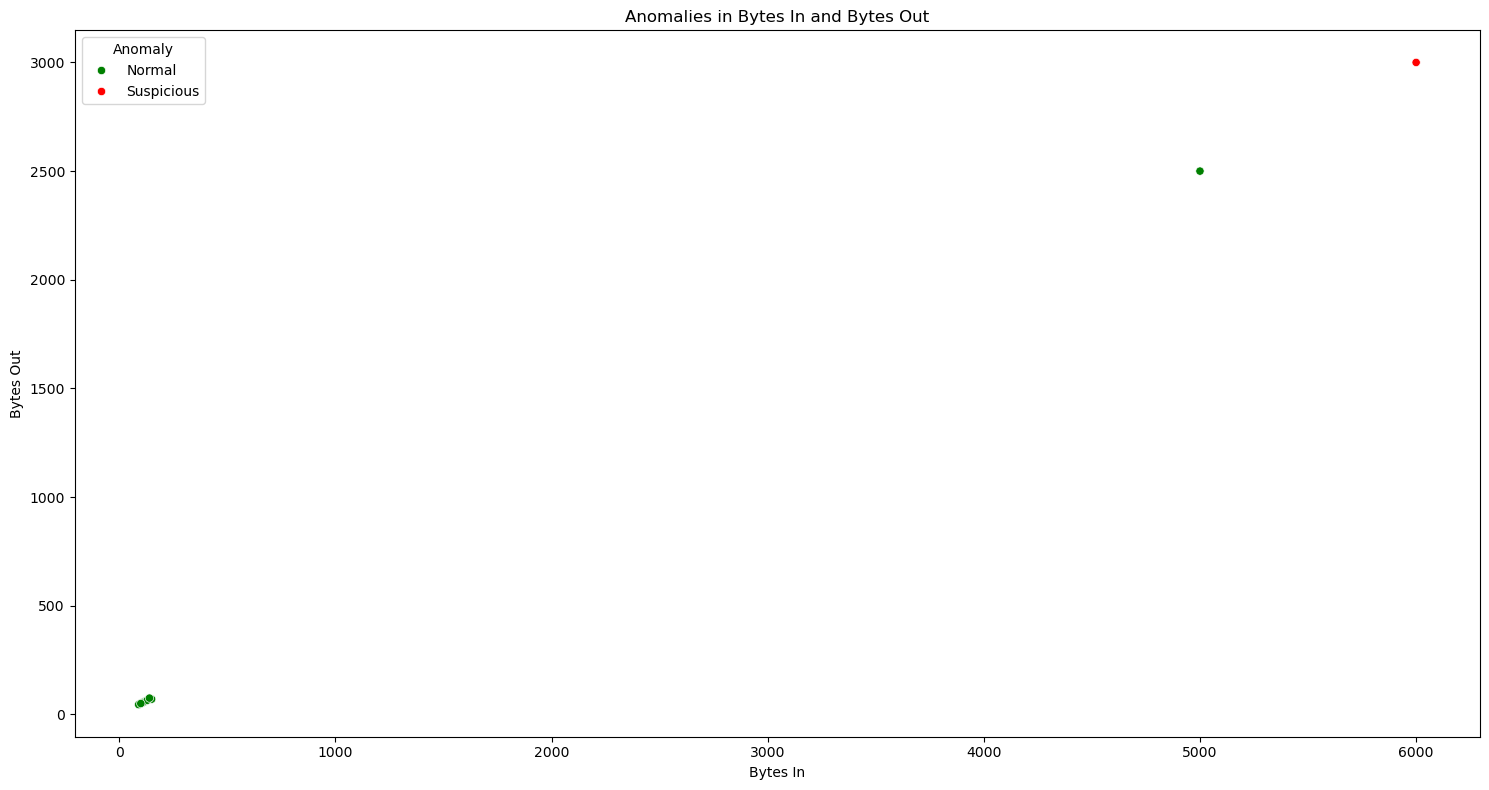

In [146]:
# 8. Visualization of Anomalies
# Visualize bytes_in vs bytes_out with anomalies highlighted

# Create a scatterplot to visualize anomalies
plt.figure(figsize=(15, 8))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df, palette=['green', 'red'])
plt.title('Anomalies in Bytes In and Bytes Out')
plt.xlabel('Bytes In')
plt.ylabel('Bytes Out')
plt.legend(title='Anomaly')
plt.tight_layout()
plt.show()